In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
candles = pd.read_csv("data/SPY.csv.gz", parse_dates=["date"])
candles

,date,open,high,low,close,volume
0,2000-01-03,99.6642,99.6642,96.7230,97.7734,8164300
1,2000-01-04,96.4919,96.8491,93.8764,93.9499,8089800
2,2000-01-05,94.0760,95.1474,92.2692,94.1180,12177900
3,2000-01-06,93.8659,95.1264,92.6054,92.6054,6227200
4,2000-01-07,94.3281,97.9835,94.1600,97.9835,8066500
...,...,...,...,...,...,...
5356,2021-04-19,416.2600,416.7400,413.7900,415.2100,78253813
5357,2021-04-20,413.9100,415.0859,410.5900,412.1700,81734548
5358,2021-04-21,411.5100,416.2900,411.3600,416.0700,66278473
5359,2021-04-22,415.8900,416.7800,411.1300,412.2700,97345662


In [3]:
del candles["volume"]
candles["prev_close"] = candles["close"].shift(1)
candles["gap"] = candles["open"] - candles["prev_close"]
candles["gap_percent"] = candles["gap"] / candles["prev_close"] * 100
candles["gap_filled"] = (candles["low"] <= candles["prev_close"]) & (candles["prev_close"] <= candles["high"])
candles.dropna(axis="rows", inplace=True)
candles.reset_index(drop=True, inplace=True)
candles = candles.loc[abs(candles["gap_percent"]) >= 0.05].reset_index(drop=True)
candles

,date,open,high,low,close,prev_close,gap,gap_percent,gap_filled
0,2000-01-04,96.4919,96.8491,93.8764,93.9499,97.7734,-1.2815,-1.310684,False
1,2000-01-05,94.0760,95.1474,92.2692,94.1180,93.9499,0.1261,0.134220,True
2,2000-01-06,93.8659,95.1264,92.6054,92.6054,94.1180,-0.2521,-0.267855,True
3,2000-01-07,94.3281,97.9835,94.1600,97.9835,92.6054,1.7227,1.860259,False
4,2000-01-10,98.3197,98.7608,97.5003,98.3197,97.9835,0.3362,0.343119,True
...,...,...,...,...,...,...,...,...,...
4803,2021-04-16,417.2500,417.9100,415.7300,417.2600,415.8700,1.3800,0.331834,True
4804,2021-04-19,416.2600,416.7400,413.7900,415.2100,417.2600,-1.0000,-0.239659,False
4805,2021-04-20,413.9100,415.0859,410.5900,412.1700,415.2100,-1.3000,-0.313095,False
4806,2021-04-21,411.5100,416.2900,411.3600,416.0700,412.1700,-0.6600,-0.160128,True


In [4]:
gap_fill_count = candles.groupby("gap_filled").size()
gap_fill_count

gap_filled
False    1679
True     3129
dtype: int64

In [5]:
print("Naive gap fill rate {:.2f}%".format(gap_fill_count[True]/gap_fill_count.sum()*100))

Naive gap fill rate 65.08%


In [6]:
candles["day_of_week"] = candles["date"].dt.day_name()
candles["month"] = candles["date"].dt.month_name()
candles

,date,open,high,low,close,prev_close,gap,gap_percent,gap_filled,day_of_week,month
0,2000-01-04,96.4919,96.8491,93.8764,93.9499,97.7734,-1.2815,-1.310684,False,Tuesday,January
1,2000-01-05,94.0760,95.1474,92.2692,94.1180,93.9499,0.1261,0.134220,True,Wednesday,January
2,2000-01-06,93.8659,95.1264,92.6054,92.6054,94.1180,-0.2521,-0.267855,True,Thursday,January
3,2000-01-07,94.3281,97.9835,94.1600,97.9835,92.6054,1.7227,1.860259,False,Friday,January
4,2000-01-10,98.3197,98.7608,97.5003,98.3197,97.9835,0.3362,0.343119,True,Monday,January
...,...,...,...,...,...,...,...,...,...,...,...
4803,2021-04-16,417.2500,417.9100,415.7300,417.2600,415.8700,1.3800,0.331834,True,Friday,April
4804,2021-04-19,416.2600,416.7400,413.7900,415.2100,417.2600,-1.0000,-0.239659,False,Monday,April
4805,2021-04-20,413.9100,415.0859,410.5900,412.1700,415.2100,-1.3000,-0.313095,False,Tuesday,April
4806,2021-04-21,411.5100,416.2900,411.3600,416.0700,412.1700,-0.6600,-0.160128,True,Wednesday,April


In [7]:
# Bucket gap_percent by size
number_of_buckets = 10
interval_size = 0.1
min_val = 0.05

cut_bins = [round(z, 2) for z in np.arange(0.05, min_val + number_of_buckets * interval_size, interval_size)] + [100]
cut_labels = [round(z + interval_size / 2, 2) for z in np.arange(0.05, min_val + number_of_buckets * interval_size, interval_size)]

candles["gap_size"] = pd.cut(abs(candles["gap_percent"]), bins=cut_bins, labels=cut_labels)
candles

,date,open,high,low,close,prev_close,gap,gap_percent,gap_filled,day_of_week,month,gap_size
0,2000-01-04,96.4919,96.8491,93.8764,93.9499,97.7734,-1.2815,-1.310684,False,Tuesday,January,1.0
1,2000-01-05,94.0760,95.1474,92.2692,94.1180,93.9499,0.1261,0.134220,True,Wednesday,January,0.1
2,2000-01-06,93.8659,95.1264,92.6054,92.6054,94.1180,-0.2521,-0.267855,True,Thursday,January,0.3
3,2000-01-07,94.3281,97.9835,94.1600,97.9835,92.6054,1.7227,1.860259,False,Friday,January,1.0
4,2000-01-10,98.3197,98.7608,97.5003,98.3197,97.9835,0.3362,0.343119,True,Monday,January,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
4803,2021-04-16,417.2500,417.9100,415.7300,417.2600,415.8700,1.3800,0.331834,True,Friday,April,0.3
4804,2021-04-19,416.2600,416.7400,413.7900,415.2100,417.2600,-1.0000,-0.239659,False,Monday,April,0.2
4805,2021-04-20,413.9100,415.0859,410.5900,412.1700,415.2100,-1.3000,-0.313095,False,Tuesday,April,0.3
4806,2021-04-21,411.5100,416.2900,411.3600,416.0700,412.1700,-0.6600,-0.160128,True,Wednesday,April,0.2


In [8]:
gap_fill_by_size = candles.groupby(["gap_size", "gap_filled"]).size()
gap_fill_by_size.groupby("gap_size").apply(lambda g: g / g.sum() * 100)

gap_size  gap_filled
0.1       False         10.829960
          True          89.170040
0.2       False         26.596980
          True          73.403020
0.3       False         30.878187
          True          69.121813
0.4       False         38.264300
          True          61.735700
0.5       False         43.781095
          True          56.218905
0.6       False         47.703180
          True          52.296820
0.7       False         48.648649
          True          51.351351
0.8       False         57.142857
          True          42.857143
0.9       False         57.600000
          True          42.400000
1.0       False         62.786596
          True          37.213404
dtype: float64

Gap fill rates decrease as the gap size increases.

In [9]:
gap_fill_by_month = candles.groupby(["month", "gap_filled"]).size()
gap_fill_by_month.groupby("month").apply(lambda g: g / g.sum() * 100)

month      gap_filled
April      False         33.501259
           True          66.498741
August     False         34.515366
           True          65.484634
December   False         35.492228
           True          64.507772
February   False         29.838710
           True          70.161290
January    False         33.416459
           True          66.583541
July       False         36.567164
           True          63.432836
June       False         33.415233
           True          66.584767
March      False         35.585586
           True          64.414414
May        False         36.523929
           True          63.476071
November   False         36.870027
           True          63.129973
October    False         34.515366
           True          65.484634
September  False         38.786280
           True          61.213720
dtype: float64

Month has no discernible effect on gap fill rate.

In [10]:
gap_fill_by_day_of_week = candles.groupby(["day_of_week", "gap_filled"]).size()
gap_fill_by_day_of_week.groupby("day_of_week").apply(lambda g: g / g.sum() * 100)

day_of_week  gap_filled
Friday       False         34.291581
             True          65.708419
Monday       False         41.406250
             True          58.593750
Thursday     False         33.718487
             True          66.281513
Tuesday      False         35.236220
             True          64.763780
Wednesday    False         30.412371
             True          69.587629
dtype: float64

Monday has a slightly lower gap fill rate.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [12]:
# One-hot encode categorical features like day_of_week and month
day_of_week = pd.get_dummies(candles["day_of_week"])
month = pd.get_dummies(candles["month"])
x = candles[["gap_size"]].join([day_of_week, month])
x

,gap_size,Friday,Monday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
0,1.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0.3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.3,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803,0.3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4804,0.2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4805,0.3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4806,0.2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
y = candles["gap_filled"].replace({True: "Filled", False: "NoFill"})
y

0       NoFill
1       Filled
2       Filled
3       NoFill
4       Filled
         ...  
4803    Filled
4804    NoFill
4805    NoFill
4806    Filled
4807    NoFill
Name: gap_filled, Length: 4808, dtype: object

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train)

LogisticRegression()

In [16]:
logistic_predictions = logistic.predict(x_test)
print("Logistic Regression accuracy {:.1%}".format(metrics.accuracy_score(y_test, logistic_predictions)))

Logistic Regression accuracy 69.5%


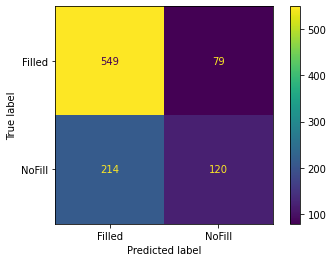

In [17]:
metrics.plot_confusion_matrix(logistic, x_test, y_test)

In [18]:
svm_model = svm.LinearSVC()
svm_model.fit(x_train, y_train)

LinearSVC()

In [19]:
svm_predictions = svm_model.predict(x_test)
print("SVM accuracy {:.1%}".format(metrics.accuracy_score(y_test, svm_predictions)))

SVM accuracy 69.5%


In [20]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [21]:
tree_predictions = tree.predict(x_test)
print("Random Forest accuracy {:.1%}".format(metrics.accuracy_score(y_test, tree_predictions)))

Random Forest accuracy 69.4%


In [22]:
# Partial gap fill
conditions = [candles["gap_filled"] == True, candles["gap_percent"] > 0, candles["gap_percent"] < 0]
choices = [math.nan, candles["low"] - candles["prev_close"], candles["high"] - candles["prev_close"]]

candles["remaining_gap"] = np.select(conditions, choices)
candles["partial_gap_fill_percent"] = 1 - candles["remaining_gap"] / candles["gap"]
partial_fill = candles.dropna()
partial_fill

,date,open,high,low,close,prev_close,gap,gap_percent,gap_filled,day_of_week,month,gap_size,remaining_gap,partial_gap_fill_percent
0,2000-01-04,96.4919,96.8491,93.8764,93.9499,97.7734,-1.2815,-1.310684,False,Tuesday,January,1.0,-0.9243,0.278736
3,2000-01-07,94.3281,97.9835,94.1600,97.9835,92.6054,1.7227,1.860259,False,Friday,January,1.0,1.5546,0.097579
5,2000-01-11,98.0255,98.2146,96.4709,97.1432,98.3197,-0.2942,-0.299228,False,Tuesday,January,0.3,-0.1051,0.642760
7,2000-01-13,97.1222,97.9835,96.3238,97.4793,96.1768,0.9454,0.982981,False,Thursday,January,1.0,0.1470,0.844510
8,2000-01-14,98.5087,99.1390,98.1306,98.8028,97.4793,1.0294,1.056019,False,Friday,January,1.0,0.6513,0.367301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,2021-04-08,407.9300,408.5800,406.9300,408.5200,406.5900,1.3400,0.329570,False,Thursday,April,0.3,0.3400,0.746269
4802,2021-04-15,413.7400,416.1600,413.6900,415.8700,411.4500,2.2900,0.556568,False,Thursday,April,0.6,2.2400,0.021834
4804,2021-04-19,416.2600,416.7400,413.7900,415.2100,417.2600,-1.0000,-0.239659,False,Monday,April,0.2,-0.5200,0.480000
4805,2021-04-20,413.9100,415.0859,410.5900,412.1700,415.2100,-1.3000,-0.313095,False,Tuesday,April,0.3,-0.1241,0.904538


In [23]:
print("Naive partial gap fill reaches {:.2f}% on average".format(partial_fill["partial_gap_fill_percent"].mean()*100))
print(partial_fill.groupby(["gap_size"])["partial_gap_fill_percent"].quantile(0.3))

Naive partial gap fill reaches 49.40% on average
gap_size
0.1    0.315841
0.2    0.345515
0.3    0.283748
0.4    0.235451
0.5    0.245628
0.6    0.272220
0.7    0.220593
0.8    0.256527
0.9    0.198699
1.0    0.224903
Name: partial_gap_fill_percent, dtype: float64


The 30th percentile is around 20% (i.e. majority of no-fills filled at least 20%). This implies that there is still trading opportunity when the gap size is large with a more conservative target price.